# 实战Kaggle比赛：预测房价

In [1]:
#导入第三方库
import hashlib, os, tarfile, zipfile, requests

In [2]:
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
#实现download函数用来下载数据集，将数据集保存在本地目录
def download(name, cache_dir= os.path.join('..', 'data')): #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok= True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    #判断本地是否有这个文件，如果有则直接使用，跳过下载
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream= True, verify= True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
#下载并压缩zip/tar文件
def download_extract(name, folder= None): #@save
    """下载并解压tar/zip文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname) 
    #判断是zip文件还是tar文件，然后采取对应的下载方式
    if ext == 'zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext == 'tar':
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

#下载文件
def download_all(): #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
#使用上方的自定义脚本下载并缓存Kaggle房屋数据集
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
#使用pandas库分别加载包含训练数据和测试数据的两个csv文件
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


In [8]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [9]:
#查看前四行的前四个以及后两个特征
print(train_data.iloc[0:4, [0, 1, 2, 3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleCondition  SalePrice
0   1          60       RL         65.0        Normal     208500
1   2          20       RL         80.0        Normal     181500
2   3          60       RL         68.0        Normal     223500
3   4          70       RL         60.0       Abnorml     140000


In [10]:
#将id特征从特征中去除
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
#导致只有330个特征的原因，有些python语言版本会将none和na都当作缺失值，这导致none类型被错误理解为缺失值
all_features.shape

(2919, 79)

In [11]:
#进行数据预处理
#若无法获取测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x :(x- x.mean()) / (x.std()))
#标准化数据之后，所有均值消失，将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [12]:
#dummy_na = True将'na'设置为有效的特征值，并为其创建字符特征
#错误原因：某些ide独热编码时会将数据处理成boolean类型，需要指定处理类型为数值型，如int
all_features = pd.get_dummies(all_features, dummy_na= True, dtype= int)
# print(all_features.dtypes)
all_features.shape

(2919, 330)

In [13]:
#从pandas格式中提取Numpy，并将其转换为张量表示用于训练
n_train = train_data.shape[0]
#分割训练集和测试集
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [14]:
#训练一个带有损失平方的线性模型
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    """定义一个线性回归模型"""
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

房价像股票一样，我们关心的是相对数量，而不是绝对数量
因此，我们更关心相对误差，使用以下的均方根误差：

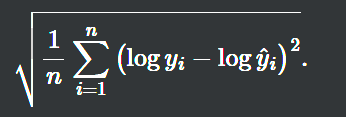


In [15]:
def log_rmse(net, features, labels):
    """定义均方误差的对数为损失"""
    #为了稳定数值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [26]:
#使用Adam优化器进行参数优化，主要好处是他对于初始学习率不敏感
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    #使用Adam算法作为优化器
    optimizer = torch.optim.Adam(net.parameters(), 
                                 lr= learning_rate, 
                                 weight_decay= weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #不带入梯度计算
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()

        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    
    return train_ls, test_ls

In [22]:
#k折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:   
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [24]:
#使用k折交叉验证中训练K次后，返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, 
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel= 'epoch', ylabel= 'rmse', xlim= [1, num_epochs],
                     legend=['train', 'valid'], yscale= 'log')
        print(f'折{i + 1}, 训练log rmse{float(train_ls[-1]):f},'
              f'验证log rmse{float(valid_ls[-1]):f}')
    #返回平均误差
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170305, 验证log rmse0.156959
折2，训练log rmse0.162019, 验证log rmse0.189309
折3，训练log rmse0.163561, 验证log rmse0.168566
折4，训练log rmse0.168018, 验证log rmse0.154335
折5，训练log rmse0.162814, 验证log rmse0.182518
5折验证:平均误差log rmse: 0.165344, 平均验证log rmse:0.170337


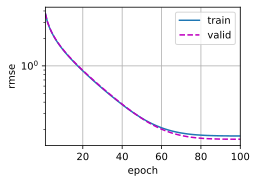

In [38]:
#设置超参数进行模型训练
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}折验证:平均误差log rmse: {float(train_l):f}, '
      f'平均验证log rmse:{float(valid_l):f}')

In [33]:
import numpy

In [39]:
#提交kaggle预测
def train_and_pred(train_features, train_labels, test_features, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    #定义线性模型
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                         num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel= 'epoch', 
             ylabel='log rmse', xlim=[1, num_epochs], yscale= 'log')
    print(f'训练log rmse: {float(train_ls[-1]):f}')
    #将网络应用于测试集
    preds = net(test_features).detach().numpy()
    #格式化导出到Kaggle进行提交
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis= 1)
    submission.to_csv('submission.csv', index= False)

训练log rmse: 0.162161


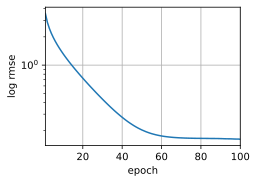

In [43]:
train_and_pred(train_features, train_labels, test_features, test_data,
               num_epochs, lr, weight_decay, batch_size)